# Introduction

This work is a part of my application process for the Data Scientist role at Ahrefs.

## Objective

Our primary goal is to develop a model that can predict if an image is relevant or not to the respective query provided. The solution needs to be able to classify the **irrelevant candidate**. This capability is crucial for search engine optimisation on image search. 

## Scoring Criteria

Scoring criteria will be based on AUC ROC metric. The baseline AUC value for 'dumb' classifier which choose all majority class is 0.5 (base value to beat).

## Assumptions

The following table outlines the assumptions made during the development of this model. These are critical for understanding the scope and limitations of the solution provided.

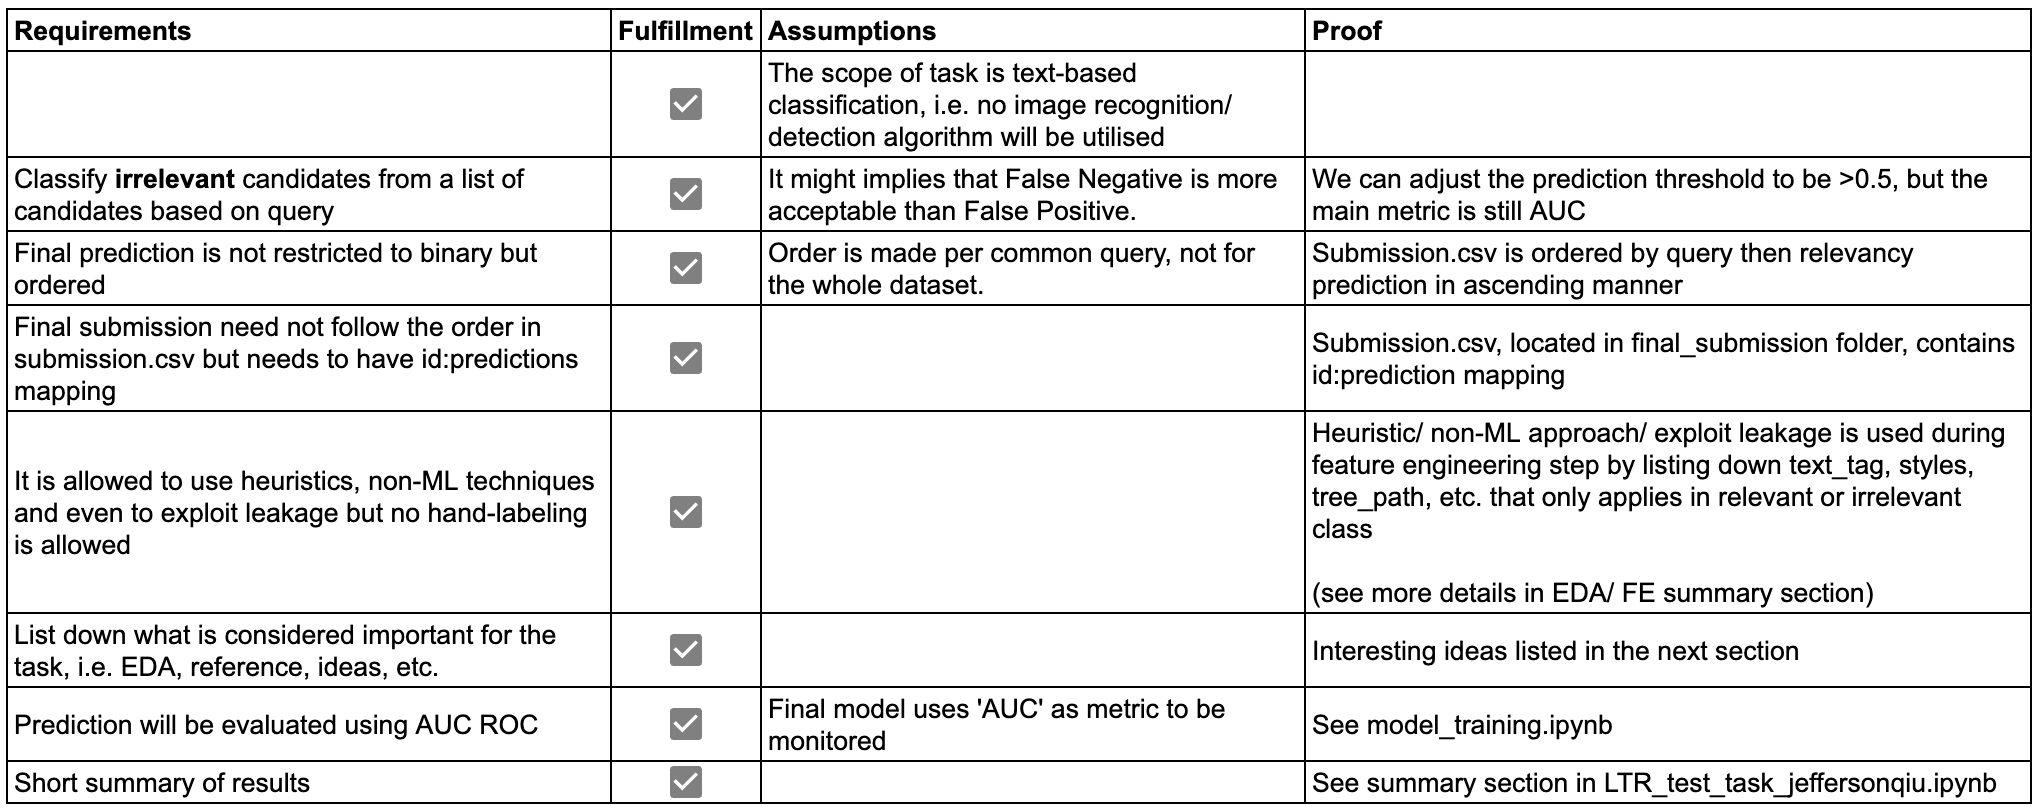

## Interesting Ideas/ Findings/ Frustration



This problem is novel as we aim to determine the image's relevancy without directly looking at the image itself. Therefore, it is vital to devise a strategy extract as much information as possible about the context surrounding the image to solve the problem effectively.

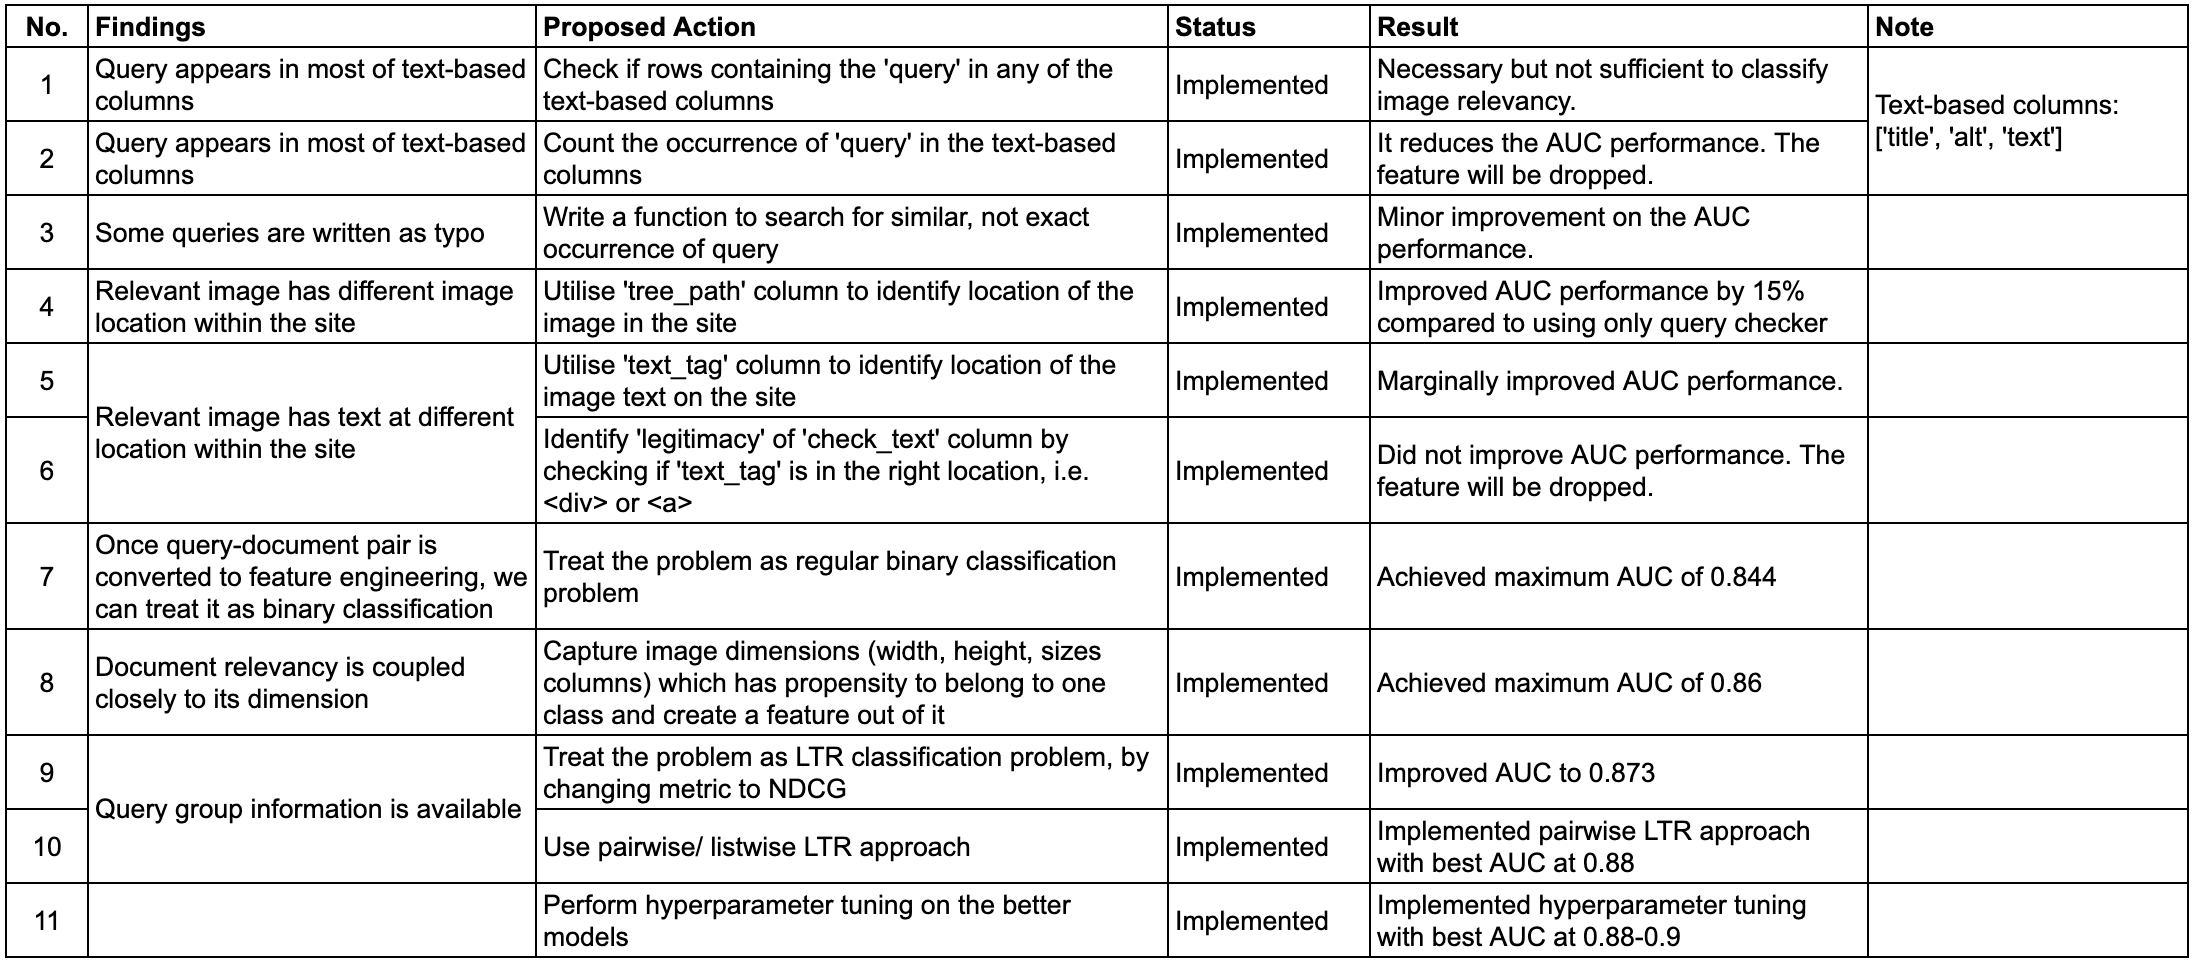

## Summary of EDA and Feature Engineering

#### HTML Definition

After further exploration on the data, here are the definitions for the column in the dataset.<br>
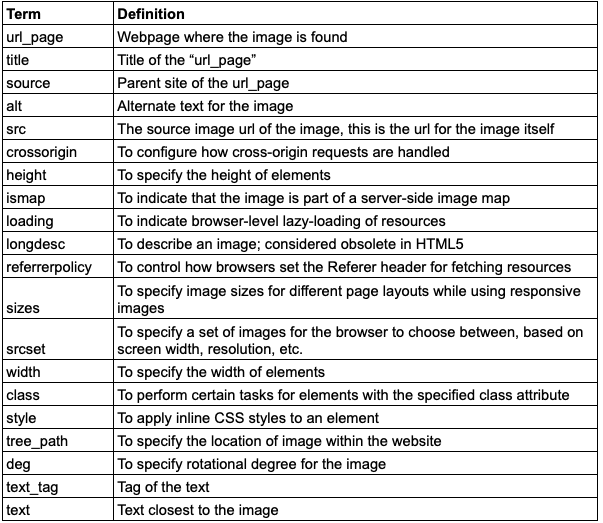




**EXPERT ADVISORY:**
**Just read this part and skip the actual EDA/ FE to dodge potential torment!**

In my observation, the key for this problem lies heavily on the EDA and FE section. A feature that seemingly has no correlation to the relevancy of the document can held such a key role in the model building. I spent a good amount of time (and space in this notebook) on both sections and going through the script can be very taxing. 

Therefore, I have summarised what I did in the table below (still very long, my bad!): <br>
*Note that I used the term 'class' to refer to is_relevant grouping, not actual 'class' column*
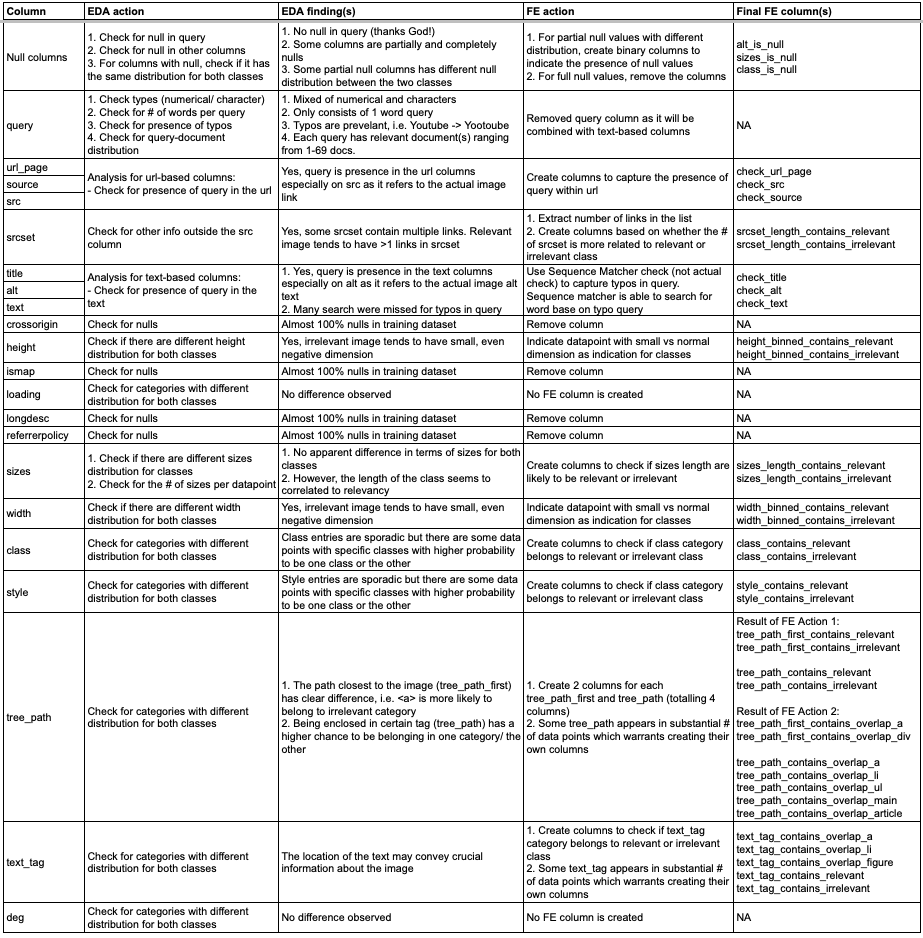

## Feature and Model Selection
### Feature Selection

The feature selection process is conducted to address the issue of parameter collinearity, which can degrade the performance of the model by obscuring the individual impact of parameters. The procedure for eliminating features is as follows:
1. Identify and eliminate one feature from each pair exhibiting a correlation greater than 0.7.
2. Verify that the Variance Inflation Factor (VIF) – a quantifier of multicollinearity in regression analyses – is below 10. If so, proceed with modeling; if not, revisit the first step.

### Model Selection

Three types of models are explored: 
1. Decision Trees-based boosting methods (Light Gradient Boosting Machine [LGBM], Random Forest, CatBoost Model)
2. Probabilistic model (Naive Bayes)
3. Linear Model (Logistic Regression)

A standard parameter training is done for each model. The results for this round are compared based on AUC score. From this, two models stood out as the best performing models, i.g. LGBM and CatBoost Model. 

**Note:** only LGBM model captures the groupping of the query. This allows a traditional Learning to Rank metric (Normalized Discounted Cummulative Gains [NDCG]) and algorithm (pairwise method) to be used. 

### Hyperparameter Tuning

The selected models, LGBM and CatBoost, were subjected to rigorous hyperparameter optimization via the Optuna framework to enhance their performance and stability. This process aims to fine-tune the models' configurations to achieve optimal results. 

Ultimately, both models showed an equally strong results as the AUC comparable with each other at **0.88-0.90 values range** (baseline score is 0.5). However, I finally selected LGBM as the final model as it can be trained in faster than CatBoost Model, thereby, showing its superiority overall. 

### Feature Importance Analysis

Both models showing a different but sensible set of top performing features.
1. LGBM model favors more text-based columns such as alt-text, text description or the url name of the image
2. CatBoost model favors more subtle features such as image location (Tree-path) and image's html attributes such as its dimension

### Final Result

The optimal parameters, identified through the hyperparameter tuning process, were applied to train the model on the entire dataset, to establish the finalized model. This model was subsequently deployed for inference on the test dataset.

The outcomes of the prediction are presented in the form of an id:prediction mapping, where the prediction is provided as a probability value. In this format, a higher value denotes a greater likelihood for relevant document.

## Potential for Improvements

Due to limited time, I didn't manage to complete this initial to do-list:
1. Implement a listwise algorithm on TensorFlow.
2. Utilise a more advanced NLP techniques to pull insights out of the text-based columns such as BM25, BERT, etc.
3. Consider using PR-AUC to observe actual model performance on imbalance-class.
4. As opposed to focus only on text-based feature, we can use model such as CLIP to check the image and predict relevancy based on the query-image similarity score

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import random

from difflib import SequenceMatcher

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn import svm

import optuna
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier, LGBMRanker
from catboost import CatBoostClassifier, CatBoostRanker
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from collections import Counter

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs') # Change to root folder directory
# sys.path.pop()

In [4]:
# EDA Imports
from src.eda import null_columns_checker, column_investigator, find_unique_values, analyser_generic, tree_path_investigator
from src.eda import non_numeric_check, dimension_investigator

# FE Imports
from src.fe import indicate_nulls, fuzzy_search, dynamic_check_text, check_columns_on_query, check_columns_on_text 
from src.fe import dim_binner, check_columns_on_dim, column_dropper

# Feature Model Selectin Imports
from src.feature_model_selection import find_high_corr_pairs, manual_pr_draw, manual_auc_roc_draw, groupper

In [6]:
train_file_path= '../data/train.feather'
test_file_path= '../data/test.feather'
ori_train_df = pd.read_feather(train_file_path)
ori_test_df = pd.read_feather(test_file_path)

## Exploratory Data Analysis

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
pd.set_option('display.max_colwidth', 400)

In [9]:
ori_train_df.head(5)

,query,url_page,title,source,alt,src,crossorigin,height,ismap,loading,longdesc,referrerpolicy,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,is_relevant
0,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,Bank Routing,https://bank-routing.org/img/logo.png,None,None,None,None,None,None,None,None,None,None,None,"[a, div, nav, header, body, html]",2.0,div,Blog Contacts,3f5e067733178cc0f4b3a97cfc9c62e1,0
1,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,011103093 routing number on TD Bank NA check,https://bank-routing.org/img/routing_numbers/routing-example-011103093.png,None,None,None,None,None,None,None,None,None,img-fluid,None,"[div, div, div, main, main, body, html]",1.0,div,"Aside from the SWIFT code which each bank is delegated for transfers that are global, you should indicate that your bank routing number. This info is your bank's identifier; you're using in your city, by signaling the bank routing number, you streamline the transfer of capital. The number of TD Bank NA is 011103093; it can be used by you also. It is essential to indicate the bank. So, where to...",fe64168fa7afeefa73708113c4bc2730,1
2,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,DMCA.com Protection Status,https://images.dmca.com/Badges/dmca_protected_sml_120n.png?ID=a6611608-9929-41c8-b3a9-616af4256889,None,None,None,None,None,None,None,None,None,None,None,"[a, p, div, div, div, footer, body, html]",NaN,None,None,5b5c3b6560ae158bf7ecd09f5ead1841,0
3,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,Quantcast,https://pixel.quantserve.com/pixel/p-1meCEwxYU8pDX.gif,None,1,None,None,None,None,None,None,1,None,None,"[div, noscript, body, html]",3.0,body,"Blog Contacts Bank Routing Numbers -> TD Bank NA -> Maine -> 011103093 011103093 Routing Number Routing Number 011103093 Bank Name TD Bank NA Status Valid, last updated: Oct 25, 2021 Office Type Main Office Servicing FRB Number 011000015 Servicing FRB Number Address 600 Atlantic Avenue Boston, Boston, MA Address P.O. BOX 1377, LEWISTON, ME, 04240 City LEWISTON Zipcode 04240-1377 Phone (877) 89...",91fe71b49453d9037769b5a99c6f0856,0
4,011103093,https://www.gobankingrates.com/banking/banks/td-bank-routing-number-connecticut/,TD Bank Routing Number in Connecticut: 211370545 | GOBankingRates,gobankingrates.com,Loading...,https://cdn.gobankingrates.com/wp-content/themes/rockefeller-lite/assets/src/images/best-banks-2021/spinner-solid.svg.gzip,None,None,None,None,None,None,None,None,None,None,None,"[span, form, div, div, div, main, body, html]",2.0,form,Sign-Up Now Please enter an email. Please enter a valid email address. There was an unknown error. Please try again later.,021b4f809739c93f6ff913ce7389a9c9,0


#### Quick Data Review

In [10]:
total_data = len(ori_train_df)
relevant_doc_count = sum(ori_train_df['is_relevant'] == 1) 
irrelevant_doc_count = total_data - relevant_doc_count
relevant_document_rate = round(relevant_doc_count / len(ori_train_df)*100,1)
unique_queries = ori_train_df['query'].nunique()

print(f'Total document count: {total_data}')
print(f'Number of unique queries: {unique_queries}')
print(f'Relevant document rate: {relevant_document_rate}%\n')

Total document count: 607844
Number of unique queries: 733
Relevant document rate: 3.6%



In [11]:
ori_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607844 entries, 0 to 607843
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   query           607844 non-null  object 
 1   url_page        607844 non-null  object 
 2   title           607844 non-null  object 
 3   source          607844 non-null  object 
 4   alt             516612 non-null  object 
 5   src             607844 non-null  object 
 6   crossorigin     318 non-null     object 
 7   height          245583 non-null  object 
 8   ismap           9 non-null       object 
 9   loading         119335 non-null  object 
 10  longdesc        1469 non-null    object 
 11  referrerpolicy  324 non-null     object 
 12  sizes           64987 non-null   object 
 13  srcset          105818 non-null  object 
 14  width           256371 non-null  object 
 15  class           309950 non-null  object 
 16  style           77903 non-null   object 
 17  tree_path 

In [12]:
ori_train_df.describe()

,deg,is_relevant
count,423801.000000,607844.000000
mean,2.075210,0.035925
std,0.757783,0.186104
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,0.000000
max,3.000000,1.000000


### Looking at the Data

In [13]:
ori_train_df[['src', 'query', 'is_relevant']].head(6)

,src,query,is_relevant
0,https://bank-routing.org/img/logo.png,011103093,0
1,https://bank-routing.org/img/routing_numbers/routing-example-011103093.png,011103093,1
2,https://images.dmca.com/Badges/dmca_protected_sml_120n.png?ID=a6611608-9929-41c8-b3a9-616af4256889,011103093,0
3,https://pixel.quantserve.com/pixel/p-1meCEwxYU8pDX.gif,011103093,0
4,https://cdn.gobankingrates.com/wp-content/themes/rockefeller-lite/assets/src/images/best-banks-2021/spinner-solid.svg.gzip,011103093,0
5,https://cdn.gobankingrates.com/wp-content/uploads/2017/05/TD-Bank-routing-number.jpg?w=675&quality=75,011103093,0


In [14]:
ori_train_df[['src', 'query', 'is_relevant']].sample(6)

,src,query,is_relevant
284431,https://bulk.fsp-europe.com/wcontent/uploads/2016/04/fsp500-60ega_label_fan-298x300.png,fsp,0
424082,https://static.bimago.pl/mediacache/catalog/product/cache/5/1/134915/image/750x1120/5484e9a88c740fc4955d1ca58aff33e7/134915_6.jpg,penetratation,0
67813,https://static.tvtropes.org/pmwiki/pub/images/ArchangelMichael3_8396.jpg,arcangels,1
392920,https://acloreinteriors.com/wp-content/uploads/2016/01/3845d5ea8812698e77e802f0cbb1032c.jpg,myfoxorlando,0
457850,https://i.dailymail.co.uk/1s/2021/10/26/11/49650563-0-image-a-27_1635243076325.jpg,ragen,0
434884,https://www.vvponline.nl/cache/0/3/d/0/5/03d053f4f9ac0816ac7c5327ced72bb0b3ac8ec1.jpeg,polismap,0


In [15]:
ori_train_df.iloc[188892]

query                                                                                                       cablbar
url_page          https://www.skimble.com/exercises/59300-cable-bar-standing-decline-chest-press-how-to-do-exercise
title                        Cable Bar Standing Decline Chest Press - Exercise How-to - Workout Trainer  by Skimble
source                                                                                                  skimble.com
alt                                                      How to do: Cable Bar Standing Decline Chest Press - Step 1
src                                           https://s3.amazonaws.com/prod.skimble/assets/2137228/image_iphone.jpg
crossorigin                                                                                                    None
height                                                                                                         None
ismap                                                                   

**Key Points:**
- Apart from the relevant pictures, irrelevant pictures contains logos, profile pictures, random assets, etc. that the site contains.
- **Many relevant images do not contains the query** in the src while **many irrelevant images contain the query in the src**.
- As we are not to open each picture one by one, we need to find a way to tell if the picture is relevant just based on other html information.

### Query Column

In [16]:
unique_relevant_results = sum(ori_train_df.groupby('query').agg({'is_relevant': 'max'})['is_relevant'])
all_query_has_relevant_doc = unique_queries == unique_relevant_results

print(f'Is each query has corresponding relevant document(s): {all_query_has_relevant_doc}')

Is each query has corresponding relevant document(s): True


In [17]:
unique_queries = ori_train_df['query'].unique()
unique_queries[:50]

array(['011103093', 'acdsee', 'ajw', 'alltvshows', 'anupama', 'asshai',
       'athleticism', 'bintje', 'brwves', 'curiouse', 'dorma', 'dotf',
       'eldery', 'expiratory', 'freepsports', 'huohu', 'kandil', 'kimaya',
       'koshas', 'kronenwetter', 'lazik', 'leucorrhea', 'minneapolus',
       'naisha', 'nmtcb', 'novitex', 'nyloplast', 'pidget', 'prevaile',
       'redtubexvideos', 'rendered', 'samule', 'sheeik', 'sologne',
       'synthesio', 'thethao24h', 'udump', 'usd287', 'veriscan', 'vetbiz',
       'weaponology', '1652', '1919gogo', '1password7', '23xi', '326',
       '351427', '4uhair', '5972', '60504'], dtype=object)

In [18]:
# Check the number of words in each query

dict(Counter([len(item.split()) for item in unique_queries]))

{1: 733}

In [19]:
query_counts = ori_train_df.groupby('query').agg(
    relevant_count=('is_relevant', 'sum'),
    total_count=('is_relevant', 'count')
)
query_counts['relevant_percentage'] = round((query_counts['relevant_count'] / query_counts['total_count']) * 100, 1)
query_counts.sample(5)

,relevant_count,total_count,relevant_percentage
query,,,
amerigroup,5,59,8.5
senuality,45,895,5.0
nyloplast,9,92,9.8
ofcs,29,827,3.5
samule,45,830,5.4


In [20]:
# Calculate averages and max/min values
average_relevant_count = round(query_counts['relevant_count'].mean())
average_relevant_percentage = round(query_counts['relevant_percentage'].mean(), 1)
max_relevant_count = query_counts['relevant_count'].max()
min_relevant_count = query_counts['relevant_count'].min()
max_relevant_percentage = query_counts['relevant_percentage'].max()
min_relevant_percentage = query_counts['relevant_percentage'].min()

# Calculate percentiles and median for relevant_count
p20_relevant_count = round(query_counts['relevant_count'].quantile(0.20))
p80_relevant_count = round(query_counts['relevant_count'].quantile(0.80))
median_relevant_count = round(query_counts['relevant_count'].median())

# Display the results
print(f'Average count of is_relevant == 1: {average_relevant_count}')
print(f'Average percentage of is_relevant == 1: {average_relevant_percentage}%')
print(f'Max count of is_relevant == 1: {max_relevant_count}')
print(f'Min count of is_relevant == 1: {min_relevant_count}')
print(f'Max percentage of is_relevant == 1: {max_relevant_percentage}%')
print(f'Min percentage of is_relevant == 1: {min_relevant_percentage}%\n')
print(f'20th percentile of relevant count: {p20_relevant_count}')
print(f'80th percentile of relevant count: {p80_relevant_count}')
print(f'Median of relevant count: {median_relevant_count}\n')


Average count of is_relevant == 1: 30
Average percentage of is_relevant == 1: 4.2%
Max count of is_relevant == 1: 69
Min count of is_relevant == 1: 1
Max percentage of is_relevant == 1: 24.1%
Min percentage of is_relevant == 1: 1.0%

20th percentile of relevant count: 18
80th percentile of relevant count: 41
Median of relevant count: 30



**Key Points**: 
- The queries consist of a combination of text and numeric strings, each being a single word.
- Some of the queries **included typos**.
- Each query doesn't have a fix number of relevant documents. Relevant documents ranges from 1 to 69 docs.
- Percentage of relevant query from total candidates ranges quite wide also from 1-24%.

### Other Columns

#### Null Columns

In our analysis, we pay special attention to the discrepancies in proportions of certain behaviors between different classes, as these discrepancies can be indicative of underlying patterns that are crucial for classification.

Consider an example where we're classifying data points into relevancy based on the presence of a specific feature, null presence in a certain column. Example:<br>

Class 0: 25% of data points have null in class == 'fake_class'.<br>
Class 1: 50% of data points have null in class == 'fake_class'.<br>

The discrepancy here is not just a numerical difference but a significant indicator of how each class is characterized by this feature. Specifically, data points in Class 1 are **twice** (50%/25%) as likely to exhibit the feature null in class == 'fake_class' compared to those in Class 0.

*Understanding Discrepancies **Ratio***:<br>
The proportion of data points (**Ratio**) exhibiting a particular behavior within each class can be thought of as a signature or fingerprint of that class. This analysis will be repeated for each column to extract as much information as possible to train our model.

In [21]:
check_df, null_check_columns, columns_to_drop = null_columns_checker(ori_train_df, 0.9, 1.1)
check_df

null_check_columns:  ['alt', 'sizes', 'class']
columns_to_drop:  ['crossorigin', 'ismap', 'longdesc', 'referrerpolicy']


,Rel: % of Null,Irrel: % of Null,Ratio,Null Check Potential
query,0.0,0.0,NaN,False
url_page,0.0,0.0,NaN,False
title,0.0,0.0,NaN,False
source,0.0,0.0,NaN,False
alt,9.3,15.2,0.61,True
src,0.0,0.0,NaN,False
crossorigin,99.9,100.0,1.00,False
height,59.3,59.6,0.99,False
ismap,100.0,100.0,1.00,False
loading,81.4,80.3,1.01,False


**Key Points**:
- Columns with close to 100% null are not useful in providing information and shall be removed. These columns are *crossorigin*, *ismap*, *longdesc*, *loading* and *referrerpolicy*.
- Some other columns have a relatively higher difference in null value than the others. With a Ratio threshold of <0.9 or >1.1, these columns are some potential columns to be used in feature engineering: *alt*, *sizes* and *class*.

#### Text and URL Columns

Intuitively, a relevant document/ image contains a literal mention of the query within the url or alt text. 

During feature engineering phase, we can extract this information into count of occurrence, binary occurence check or any other more advanced NLP methods.

In [22]:
target_columns = ['url_page', 'title', 'source', 'alt', 'src', 'srcset', 'text']
ori_train_df[['query', 'is_relevant'] + target_columns].sample(2)

,query,is_relevant,url_page,title,source,alt,src,srcset,text
420724,palmdale,1,https://theavtimes.com/2020/10/01/palmdale-named-among-safest-cities-in-california/,Palmdale named among “Safest Cities in California”,theavtimes.com,,https://theavtimes.com/wp-content/uploads/2020/10/Palmdale-skyline-at-night.jpg,"https://theavtimes.com/wp-content/uploads/2020/10/Palmdale-skyline-at-night.jpg 864w, https://theavtimes.com/wp-content/uploads/2020/10/Palmdale-skyline-at-night-300x175.jpg 300w, https://theavtimes.com/wp-content/uploads/2020/10/Palmdale-skyline-at-night-768x447.jpg 768w",[Image via city of Palmdale]
122912,einheit,0,https://www.vectorstock.com/royalty-free-vector/deutschen-einheit-banner-set-hand-drawn-style-vector-21731765,Deutschen einheit banner set hand drawn style Vector Image,vectorstock.com,tourist poster with famous destinations vector image,https://cdn3.vectorstock.com/i/thumbs/21/12/tourist-poster-with-famous-destinations-vector-38762112.jpg,None,None


**Key Points:**
- Text-based columns can be divided into two types, i.e. human-readable columns (text_columns) such as *title*, *alt*, and *text* and url-related columns (url_columns) such as *url_page*, *source*, *src*, and *srcset*.
- The presence of a query within text_columns doesn't necessarily correlate with image relevance.
- It's observed that there's a hierarchy in the predictive value of text_columns for determining relevance. Logically, *text* ranks higher than *source*, which in turn is deemed more predictive than *url_page*.


#### Tree Path
Intuitively, Tree path is another interesting avenue to obtain crucial information about whether or not the image is relevant. 

For example, if we are looking for an image of 'microscope' and the search engine shows us wikipedia page, it is more likely that the relevant image resides in the **body** of the site rather than the **header**.

In [23]:
ori_train_df[ori_train_df['is_relevant'] == 0][['query', 'is_relevant', 'tree_path']].sample(2)

,query,is_relevant,tree_path
380484,mia1,0,"[a, div, div, div, div, strong, p, div, div, div, div, div, div, div, div, body, html]"
151972,pantsl,0,"[a, div, div, div, div, div, div, div, section, div, body, html]"


In [24]:
ori_train_df[ori_train_df['is_relevant'] == 1][['query', 'is_relevant', 'tree_path']].sample(2)

,query,is_relevant,tree_path
568031,u0140,1,"[noscript, div, div, article, main, div, div, div, body, html]"
442546,porodoro,1,"[noscript, div, div, article, main, div, div, div, body, html]"


##### Tree Path First
= The first item in the tree_path

In [25]:
ori_train_df['tree_path_first'] = ori_train_df['tree_path'].apply(lambda x: x[0] if len(x) else None)

df = ori_train_df
column_to_investigate = "tree_path_first"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  ['p', 'figure', 'body', 'header', 'strong', 'section', 'article', 'center']
irrel_feature_potential:  ['a', 'button', 'font', 'i', 'label', 'h4', 'form', 'wix-image']
Total Data covered: 48.9%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
tree_path_first,,,,,,,
a,4644,247728,252372,41.5,21.3,42.3,0.50
div,9257,145579,154836,25.5,42.4,24.8,1.71
noscript,2080,94677,96757,15.9,9.5,16.2,0.59
span,537,22420,22957,3.8,2.5,3.8,0.66
p,1659,13986,15645,2.6,7.6,2.4,3.17
figure,1259,14724,15983,2.6,5.8,2.5,2.32
picture,637,10389,11026,1.8,2.9,1.8,1.61
source,528,7570,8098,1.3,2.4,1.3,1.85
li,296,7793,8089,1.3,1.4,1.3,1.08


**Key Points:**
- The table above shows that if the image is enclosed within *a*  tag (link), it is twice more likely that the image is irrelevant than it is relevant.
- We will do feature selection based on two data points from this table, i.e. Occurrence in Data (how much potential data points relevant to this observation) and Ratio (how big is the difference between behaviour shown by relevant/ irrelevant group). 

In [26]:
col = 'tree_path'
relevant_df = ori_train_df[ori_train_df['is_relevant'] == 1]
irrelevant_df = ori_train_df[ori_train_df['is_relevant'] == 0]
path_rel_set = find_unique_values(ori_train_df[ori_train_df['is_relevant'] == 1], col)
path_irrel_set = find_unique_values(ori_train_df[ori_train_df['is_relevant'] == 0], col)
path_overlaps_set = path_rel_set & path_irrel_set
path_unique_rel_set = path_rel_set - path_irrel_set
path_unique_irrel_set = path_irrel_set - path_rel_set

In [27]:
path_unique_set = find_unique_values(ori_train_df, 'tree_path')

In [28]:
len(path_unique_set)

627

Let's first check if there is any specific sections for only irrelevant or relevant image. 

In [29]:
path_unique_rel_count = len(path_unique_rel_set)
path_unique_irrel_count = len(path_unique_irrel_set)

path_unique_rel_occurrence = round(sum(analyser_generic(relevant_df, path_unique_rel_set, 'tree_path')['total_count']))
path_unique_irrel_occurrence = round(sum(analyser_generic(irrelevant_df, path_unique_irrel_set, 'tree_path')['total_count']))

In [30]:
print(f'Count of distinct sections unique to relevant images: {path_unique_rel_count} sections')
print(f'Count of data points which consists section(s) unique to relevant sections: {path_unique_rel_occurrence} data points\n')

print(f'Count of distinct sections unique to irrelevant images: {path_unique_irrel_count} sections')
print(f'Count of data point which consists section(s) unique to irrelevant sections: {path_unique_irrel_occurrence} data points')

Count of distinct sections unique to relevant images: 27 sections
Count of data points which consists section(s) unique to relevant sections: 36 data points

Count of distinct sections unique to irrelevant images: 437 sections
Count of data point which consists section(s) unique to irrelevant sections: 8079 data points


**Key Points:**
- This section explores the number of unique section only appearing in either relevant or irrelevant groups
- If test data contains similar tree_path, there is a chance we can train our model with these feature to predict query-document relevancy

In [31]:
df = ori_train_df
text_set = path_unique_set
column_to_investigate = 'tree_path'
minimum_occurrence = 10
lower_threshold = 0.5
upper_threshold = 2
path_combined_df, rel_feature_potential, irrel_feature_potential = tree_path_investigator(df, text_set, 
                                                                                          column_to_investigate, 
                                                                                          minimum_occurrence, 
                                                                                          lower_threshold, 
                                                                                          upper_threshold)

rel_feature_potential:  ['figure', 'p', 'strong', 'amp-img', 'details', 'readme-toc', 'pre', 'task-lists', 'textarea', 'app-layout', 'ps-carousel', 'app-person', 'object', 'tw-wrapper', 'app-project-detail', 'z-widget', 'bodyclass', 'devsite-content', 'flo-header-layout', 'flo-root', 'app', 'fontcolor', 'root', 'index', 'merchant-detail', 'discovery', 'merchant-p0-info', 'app-person-header', 'flo-collection', 'spand', 'tab-item', 'article-content-flex2019', 'tab-list', 'lazy-hydrate', 'single-item', 'app-create-meme', 'hero-image']
irrel_feature_potential:  ['a', 'li', 'ul', 'header', 'footer', 'aside', 'nav', 'ol', 'head', 'dl', 'yelp-react-root', 'dd', 'label', 'dt', 'template', 'i', 'h4', 'wix-image', 'phoenix-card', 'phoenix-super-link', 'phoenix-hub', 'phoenix-non-personalized-recommendations-tracking', 'chrome', 'mat-sidenav-container', 'entity-v2', 'mat-sidenav-content', 'page-layout', 'page-centered-layout', 'mat-card', 'cb-image', 'section-card', 'hub-list-card', 'profile-sect

In [32]:
path_combined_df.head(25)

,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
html,21837.0,586007.0,607844.0,100.000000,100.00,100.00,1.00
body,21809.0,581374.0,603183.0,99.233191,99.87,99.21,1.01
div,21502.0,571313.0,592815.0,97.527491,98.47,97.49,1.01
a,6176.0,385154.0,391330.0,64.380005,28.28,65.73,0.43
li,1221.0,159887.0,161108.0,26.504827,5.59,27.28,0.20
ul,1095.0,145256.0,146351.0,24.077066,5.01,24.79,0.20
main,7300.0,133493.0,140793.0,23.162686,33.43,22.78,1.47
section,5458.0,134643.0,140101.0,23.048841,24.99,22.98,1.09
article,6990.0,102321.0,109311.0,17.983397,32.01,17.46,1.83
noscript,2351.0,102425.0,104776.0,17.237317,10.77,17.48,0.62


**Key Points:**
- It is observed that there are a few sections such as *a*, *li* and *ul* which has a higher chance to be in irrelevant category while images shown in *main*, *article*, *figure* are more likely to be of relevant category. 

#### Text Tag

In [33]:
ori_train_df[ori_train_df['is_relevant'] == 1][['text_tag', 'is_relevant']].sample(5)

,text_tag,is_relevant
171779,None,1
324592,li,1
60500,None,1
419958,div,1
190864,None,1


In [34]:
ori_train_df[ori_train_df['is_relevant'] == 0][['text_tag', 'is_relevant']].sample(5)

,text_tag,is_relevant
91344,div,0
578971,None,0
541975,None,0
36079,None,0
387473,None,0


In [35]:
df = ori_train_df
column_to_investigate = "text_tag"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  ['figure', 'article', 'td', 'section', 'header', 'main']
irrel_feature_potential:  ['a', 'li', 'body', 'tr', 'head', 'ul', 'button', 'form', 'footer', 'nav', 'aside', 'h4', 'dl', 'h3']
Total Data covered: 30.3%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
text_tag,,,,,,,
div,10281,207934,218215,35.9,47.1,35.5,1.33
a,474,82967,83441,13.7,2.2,14.2,0.15
li,146,34255,34401,5.7,0.7,5.8,0.12
figure,1425,15931,17356,2.9,6.5,2.7,2.41
p,568,8573,9141,1.5,2.6,1.5,1.73
article,789,7186,7975,1.3,3.6,1.2,3.00
body,137,7922,8059,1.3,0.6,1.4,0.43
span,214,7065,7279,1.2,1.0,1.2,0.83
tr,61,5584,5645,0.9,0.3,1.0,0.30


**Key Points**:
- Like Tree Path, the position of text (captured by text_tag) is also as crucial relative to its content.
- As demonstrated, an image is likely relevant if text_tag indicates div, but likely irrelevant with a. Technically, div doesn't really mean anything in html but a shows link tag. This is the same observation as what we uncover in tree_path_first analysis.

#### Height
The motivation to explore this feature is to see if irrelevant documents have extremely small/ large dimension while relevant documents have more 'normal' size.

In [36]:
ori_train_df[ori_train_df['is_relevant'] == 1][['height', 'is_relevant']].sample(5)

,height,is_relevant
251511,350,1
458285,None,1
124327,900,1
546863,None,1
555716,560,1


In [37]:
ori_train_df[ori_train_df['is_relevant'] == 0][['height', 'is_relevant']].sample(5)

,height,is_relevant
278390,32,0
333907,60,0
147247,54,0
436467,None,0
514694,None,0


In [38]:
df = ori_train_df
column_to_investigate = 'height'

non_numeric_check (df, column_to_investigate)

Non-numeric string count when relevant: 2.1%
Non-numeric string count when irrelevant: 1.4%


As the non-numeric count is insignificant, it will be omitted for now. 

In [39]:
df = ori_train_df
column_to_investigate = "height"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
bins = [-1000, 150, 400, 800, 1600, 1000000]
labels = ['Min - 150', '150 - 400', '400 - 800', '800 - 1600', '1600 - Max']
output_df, rel_feature_potential, irrel_feature_potential = dimension_investigator(df, bins, labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

output_df

rel_feature_potential:  ['400 - 800', '800 - 1600', '1600 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 26.0%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,313,1.43,108828,18.57,17.96,0.077006
1,150 - 400,2930,13.42,75911,12.95,12.97,1.036293
2,400 - 800,3801,17.41,34180,5.83,6.25,2.986278
3,800 - 1600,1111,5.09,8064,1.38,1.51,3.688406
4,1600 - Max,291,1.33,1672,0.29,0.32,4.586207
5,Missing,13391,61.32,357352,60.98,60.99,1.005576


**Key Points:**
- Irrelevant columns tend to be very small in height. This makes sense as some of the irrelevant images are just logos. 

#### Loading

In [40]:
ori_train_df['loading'].unique()

array([None, 'lazy', 'eager', 'normal', 'false', 'auto', '', 'eagle',
       'lazyel', '1'], dtype=object)

In [41]:
df = ori_train_df
column_to_investigate = "loading"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  []
irrel_feature_potential:  ['auto']
Total Data covered: 0.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
loading,,,,,,,
lazy,3842,108676,112518,18.5,17.6,18.5,0.95
eager,179,3758,3937,0.6,0.8,0.6,1.33
auto,45,2722,2767,0.5,0.2,0.5,0.40


**Key Points:**
- The *loading* column does not show a distinct variation in behavior between relevant and irrelevant documents.

#### Sizes
The initial hypothesis is that there are more choices of sizes in the relevant image than it is on the irrelevant image.

In [42]:
ori_train_df[ori_train_df['is_relevant'] == 1][['sizes', 'is_relevant']].dropna().sample(5)

,sizes,is_relevant
40129,"(max-width: 625px) 100vw, 625px",1
329061,"(max-width: 1024px) 100vw, 1024px",1
69551,700px,1
176358,100vw,1
498888,"(max-width: 945px) 100vw, 765px",1


In [43]:
ori_train_df[ori_train_df['is_relevant'] == 0][['sizes', 'is_relevant']].dropna().sample(5)

,sizes,is_relevant
409210,"(max-width: 50px) 100vw, 50px",0
284303,"(max-width: 800px) 100vw, 800px",0
23165,"(max-width: 300px) 100vw, 300px",0
251238,"(max-width: 500px) 100vw, 500px",0
418429,"(max-width: 145px) 100vw, 145px",0


In [44]:
ori_train_df['sizes_length'] = ori_train_df['sizes'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [45]:
df = ori_train_df
column_to_investigate = "sizes_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df.sort_index()

rel_feature_potential:  [1.0, 3.0, 4.0]
irrel_feature_potential:  []
Total Data covered: 1.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
sizes_length,,,,,,,
1.0,353,4319,4672,0.8,1.6,0.7,2.29
2.0,3544,49909,53453,8.8,16.2,8.5,1.91
3.0,330,2618,2948,0.5,1.5,0.4,3.75
4.0,134,1108,1242,0.2,0.6,0.2,3.00
5.0,59,1919,1978,0.3,0.3,0.3,1.00


**Key Points:**
- It seems that in general, it is more likely that irrelevant images have Null value in the sizes column. This is a feature that is already captured in null_columns section above. Therefore, feature selection will need to be done at the end of feature engineering.

#### Srcset

In [46]:
ori_train_df['srcset'].unique()

array([None,
       'https://secure.gravatar.com/avatar/d7bb174ebaca9a857c475809fa2c403b?s=100&d=retro&r=g 2x',
       'https://secure.gravatar.com/avatar/ef2c241cf4591b461e7b89d6cee5c79c?s=100&d=retro&r=g 2x',
       ...,
       'https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-apm.png 1x, https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-apm@2x.png 2x',
       'https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlanta-planit.png 1x, https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlanta-planit@2x.png 2x',
       'https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlpba.png 1x, https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlpba@2x.png 2x'],
      dtype=object)

In [47]:
ori_train_df['srcset_length'] = ori_train_df['srcset'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [48]:
df = ori_train_df
column_to_investigate = "srcset_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df.sort_index()

rel_feature_potential:  [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
irrel_feature_potential:  [1.0]
Total Data covered: 9.6%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
srcset_length,,,,,,,
1.0,180,12360,12540,2.1,0.8,2.1,0.38
2.0,1479,38170,39649,6.5,6.8,6.5,1.05
3.0,1015,11883,12898,2.1,4.6,2.0,2.30
4.0,823,10422,11245,1.8,3.8,1.8,2.11
5.0,597,7885,8482,1.4,2.7,1.3,2.08
6.0,433,5434,5867,1.0,2.0,0.9,2.22
7.0,223,3029,3252,0.5,1.0,0.5,2.00
8.0,214,2215,2429,0.4,1.0,0.4,2.50
9.0,94,1275,1369,0.2,0.4,0.2,2.00


**Key Points:**
- The *Srcset* column replicates information contained in *src* column, therefore, it seems that it doesn't add any more information about document relevancy.
- However, the length of the srcset, i.e. the number of links provided within one srcset can be an indication of image relevancy.
- As shown above, the higher number of srcset, the more likely that the image is relevant.
  

#### Width

In [49]:
ori_train_df['height'].unique()[:1000]

array([           nan, 1.00000000e+00, 1.05000000e+02, 6.00000000e+01,
       4.50000000e+01, 7.50000000e+01, 1.94000000e+02, 2.00000000e+01,
       2.39000000e+02, 5.00000000e+01, 2.15000000e+02, 1.00000000e+02,
       2.40000000e+02, 1.71000000e+02, 1.20000000e+02, 1.62000000e+02,
       1.52000000e+02, 1.80000000e+02, 3.35000000e+02, 2.30000000e+01,
       1.60000000e+02, 1.65000000e+02, 1.60000000e+01, 9.70000000e+02,
       5.85000000e+02, 9.00000000e+01, 9.99900000e+03, 6.61000000e+02,
       3.20000000e+01, 4.00000000e+01, 4.12000000e+02, 3.25000000e+02,
       1.40000000e+02, 1.90000000e+01, 9.20000000e+01, 5.96000000e+02,
       8.50000000e+01, 2.75000000e+02, 6.48000000e+02, 7.39000000e+02,
       6.35000000e+02, 7.37000000e+02, 7.46000000e+02, 7.42000000e+02,
       6.47000000e+02, 8.44000000e+02, 2.92000000e+02, 6.04000000e+02,
       4.92000000e+02, 6.83000000e+02, 7.68000000e+02, 6.80000000e+02,
       6.49000000e+02, 3.05000000e+02, 8.08000000e+02, 4.64000000e+02,
      

In [50]:
df = ori_train_df
column_to_investigate = 'width'

non_numeric_check (df, column_to_investigate)

Non-numeric string count when relevant: 2.6%
Non-numeric string count when irrelevant: 1.7%


In [51]:
df = ori_train_df
column_to_investigate = "width"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
bins = [-1000, 150, 400, 800, 1600, 1000000]
labels = ['Min - 150', '150 - 400', '400 - 800', '800 - 1600', '1600 - Max']
output_df, rel_feature_potential, irrel_feature_potential = dimension_investigator(df, bins, labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

output_df

rel_feature_potential:  ['400 - 800', '800 - 1600', '1600 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 26.0%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,313,1.43,108828,18.57,17.96,0.077006
1,150 - 400,2930,13.42,75911,12.95,12.97,1.036293
2,400 - 800,3801,17.41,34180,5.83,6.25,2.986278
3,800 - 1600,1111,5.09,8064,1.38,1.51,3.688406
4,1600 - Max,291,1.33,1672,0.29,0.32,4.586207
5,Missing,13391,61.32,357352,60.98,60.99,1.005576


**Key Points:**
- Similarly to height column, irrelevant image tends to be very small while bigger images are more likely to be relevant. 

#### Class

In [52]:
ori_train_df['class'].unique()

array([None, 'img-fluid', 'attachment-full size-full wp-post-image', ...,
       'entry__image wp-post-image',
       'attachment-wabe-horizontal-medium size-wabe-horizontal-medium wp-post-image',
       'header__logo header__logo--default header__logo--narrow hide-for-large'],
      dtype=object)

In [53]:
df = ori_train_df
column_to_investigate = "class"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df.head(10)

rel_feature_potential:  ['attachment-full size-full', 'attachment-large size-large', 'attachment-post-thumbnail size-post-thumbnail wp-post-image']
irrel_feature_potential:  ['item-img', 'attachment-woocommerce_thumbnail size-woocommerce_thumbnail', 'MosaicAsset-module__thumb___epLhd', 'entry-thumb', 'avatar ', 'thumb', 'post-image', 'crp_thumb crp_featured', 'WebsiteImageSmall', 'thumbborder', 'pricelist_zoom', 'nav-team-logo', 'mr-2', 'logo', 'lazy', 'ResponsiveImageContainer-dlOMGF byslZC responsive-image__image', 'ipc-image', 'img--noscript card__img ', '_3VqQ_', ' css-xlzvdl', 'avatar avatar-80 photo', 'avatar avatar-48 photo', 'a-dynamic-image', 'a-dynamic-image p13n-sc-dynamic-image p13n-product-image', 'attachment-thumbnail size-thumbnail wp-post-image', 'attachment-thumbnail size-thumbnail', 'attachment-medium size-medium wp-post-image']
Total Data covered: 8.4%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
class,,,,,,,
img-responsive,393,7209,7602,1.3,1.8,1.2,1.50
,257,5346,5603,0.9,1.2,0.9,1.33
item-img,1,4217,4218,0.7,0.0,0.7,0.00
attachment-woocommerce_thumbnail size-woocommerce_thumbnail,24,3568,3592,0.6,0.1,0.6,0.17
MosaicAsset-module__thumb___epLhd,52,3436,3488,0.6,0.2,0.6,0.33
thumbimage,113,3256,3369,0.6,0.5,0.6,0.83
img-fluid,171,3059,3230,0.5,0.8,0.5,1.60
entry-thumb,30,2919,2949,0.5,0.1,0.5,0.20
avatar,0,3152,3152,0.5,0.0,0.5,0.00


**Key Points:**
- By definition, *class* names can be quite arbitrary. However, we can still see a pattern in which that one class is more related to either group.

#### Style

In [54]:
ori_train_df['style'].unique()

array([None, 'border:0;', 'float:right;margin-top:4px;cursor:pointer',
       ..., 'max-width:200px; max-height:200px',
       'width: 35px; height: 35px; float: left; margin-top: -8px; ',
       'max-width:232px;max-height:346px;'], dtype=object)

In [55]:
df = ori_train_df
column_to_investigate = "style"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  ['']
irrel_feature_potential:  ['display:none;', 'width:92px;height:92px;object-fit:cover;object-position:25% 25%', 'display:none', 'max-width: 100%; height: auto;', 'max-height:50px;max-width:50px;', 'max-width:64px;max-height:64px']
Total Data covered: 4.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
style,,,,,,,
display:none;,11,8255,8266,1.4,0.1,1.4,0.07
width:92px;height:92px;object-fit:cover;object-position:25% 25%,0,6476,6476,1.1,0.0,1.1,0.00
display:none,7,4832,4839,0.8,0.0,0.8,0.00
,349,2745,3094,0.5,1.6,0.5,3.20
max-width: 100%; height: auto;,3,1836,1839,0.3,0.0,0.3,0.00
max-height:50px;max-width:50px;,1,1056,1057,0.2,0.0,0.2,0.00
max-width:64px;max-height:64px,1,1448,1449,0.2,0.0,0.2,0.00


In [56]:
ori_train_df['style_length'] = ori_train_df['style'].apply(lambda x: len(x.split(';')) if x else None).dropna()

In [57]:
df = ori_train_df
column_to_investigate = "style_length"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  []
irrel_feature_potential:  [7.0]
Total Data covered: 0.2%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
style_length,,,,,,,
2.0,1014,28904,29918,4.9,4.6,4.9,0.94
3.0,456,14199,14655,2.4,2.1,2.4,0.88
4.0,295,12363,12658,2.1,1.4,2.1,0.67
1.0,357,11276,11633,1.9,1.6,1.9,0.84
5.0,99,1925,2024,0.3,0.5,0.3,1.67
6.0,38,1576,1614,0.3,0.2,0.3,0.67
7.0,18,1125,1143,0.2,0.1,0.2,0.50


**Key Points:**
- We can pick up cues about irrelevant image from *style* columns such as those showing 'display:none'. It only makes sense to not show irrelevant image, not the other way around.

#### Deg

In [58]:
ori_train_df['deg'].unique()

array([ 2.,  1., nan,  3.])

In [59]:
df = df
column_to_investigate = "deg"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  []
irrel_feature_potential:  []
Total Data covered: 0%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
deg,,,,,,,
2.0,7114,170929,178043,29.3,32.6,29.2,1.12
3.0,4303,134513,138816,22.8,19.7,23.0,0.86
1.0,4049,102893,106942,17.6,18.5,17.6,1.05


**Key Points:**
- It seems that there are no substantial behavioral difference between rotational degree between both classes. 

## Feature Engineering

### Train Test Split

In [60]:
gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 2).split(ori_train_df, groups=ori_train_df['query'])

X_train_inds, X_val_inds = next(gss)

train_data= ori_train_df.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['is_relevant'])]
y_train = train_data.loc[:, train_data.columns.isin(['is_relevant'])]

val_data= ori_train_df.iloc[X_val_inds]

#We need to keep the query for later predictions
X_val = val_data.loc[:, ~val_data.columns.isin(['is_relevant'])]
y_val = val_data.loc[:, val_data.columns.isin(['is_relevant'])]

### Remove Null Columns

In [61]:
df = pd.concat([X_train, y_train], axis=1)
check_df, null_check_columns, null_columns_to_drop = null_columns_checker(df, 0.9, 1.1)

df = X_train
columns_to_drop = null_columns_to_drop
X_train = column_dropper(df, columns_to_drop)
X_train.sample(1)

null_check_columns:  ['alt', 'sizes', 'class', 'sizes_length']
columns_to_drop:  ['crossorigin', 'ismap', 'longdesc', 'referrerpolicy']


,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length
404738,ngoma,https://sheinnovates.com/category/ngoma/,Category Ngoma | Sustainable Health Enterprises,sheinnovates.com,,http://sheinnovates.com/wp-content/uploads/2015/08/instagram.png,30.0,None,None,None,30,None,None,"[a, div, div, div, aside, div, div, footer, div, body, html]",1.0,a,Instagram,dc54acd79636a3b278d0ee6a672e5a3c,a,Min - 150,NaN,NaN,NaN


### Add Null Indicator Columns

In [62]:
df = X_train
null_check_columns = null_check_columns

X_train = indicate_nulls(df, null_check_columns)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null
221978,cumbus,https://www.etsy.com/listing/667677118/turkish-cumbus-saz-cumbush-sazs-by,Turkish Cümbüs Saz/ Cumbush Sazs by Zeynel Abidin | Etsy,etsy.com · In stock,,https://i.etsystatic.com/17719287/r/il/8438cb/3252708100/il_340x270.3252708100_j1g0.jpg,NaN,None,None,None,None,wt-rounded,None,"[div, a, aside, div, div, div, div, div, div, div, body, html]",2.0,a,"Editors' Picks Jewelry, handbags, and accessories",571f4201fcfb94cba9042910d294e5de,div,Missing,NaN,NaN,NaN,0,1,0,1


### Text Columns

In [63]:
df = X_train
target_columns = ['title', 'alt', 'text']
text_column = 'query'
function_type = 'fuzzy_check'

X_train = check_columns_on_query(df, target_columns, text_column, function_type)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text
86146,bayreuth,https://www.dg-premium.com/bayreuth-festival-2021/,Bayreuth Festival 2021 - DG Premium,dg-premium.com,,https://www.dg-premium.com/wp-content/uploads/2021/06/bayreuth-logo.jpg,190.0,lazy,"(max-width: 575px) 100vw, 575px","https://www.dg-premium.com/wp-content/uploads/2021/06/bayreuth-logo.jpg 575w, https://www.dg-premium.com/wp-content/uploads/2021/06/bayreuth-logo-300x99.jpg 300w",575,wp-image-46773,None,"[figure, div, div, div, article, main, div, div, div, body, html]",NaN,None,None,9a55b789ac19a92f9467cf62e773184b,figure,150 - 400,2.0,2.0,NaN,0,0,0,0,1,0,0


### URL Columns

In [64]:
df = X_train
target_columns = ['url_page', 'src', 'source']
text_column = 'query'
function_type = 'check'

X_train = check_columns_on_query(df, target_columns, text_column, function_type)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source
295930,gimbel,https://variety.com/2018/music/news/norman-gimbel-dead-dies-killing-me-softly-1203096430/,Norman Gimbel Dead: Lyricist Wrote 'Killing Me Softly' Words - Variety,variety.com,None,https://sb.scorecardresearch.com/p?c1=2&c2=6035310&c3=&c4=&c5=&c6=&c15=&cv=2.0&cj=1,NaN,None,None,None,None,None,None,"[noscript, body, html]",2.0,body,× Plus Icon Click to expand the Mega Menu Plus Icon Click to Expand Search Input optional screen reader Have a News Tip? Newsletters Switch edition between U.S. Edition Asia Edition Global Edition U.S. Asia Global Variety Log in Account optional screen reader Print Plus Login Subscribe to Print Plus Variety Print Plus Subscriber optional screen reader Print Plus Features Logout Help optional s...,83cd5bb62f2996fb45de0031d99a3910,noscript,Missing,NaN,NaN,NaN,1,1,1,1,1,0,1,1,0,0


### Tree Path

#### Tree Path First

In [65]:
X_train['tree_path_first'] = X_train['tree_path'].apply(lambda x: x[0] if len(x) else None)

df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "tree_path_first"
minimum_occurrence = 1
lower_threshold = 0.5
upper_threshold = 2
tpf_output_df, tpf_rel_feature_potential, tpf_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)
tpf_output_df

rel_feature_potential:  ['figure', 'p']
irrel_feature_potential:  []
Total Data covered: 5.4%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
tree_path_first,,,,,,,
a,3738,196200,199938,41.2,21.3,42.0,0.51
div,7415,116357,123772,25.5,42.2,24.9,1.69
noscript,1674,75756,77430,16.0,9.5,16.2,0.59
span,427,17484,17911,3.7,2.4,3.7,0.65
figure,1058,12528,13586,2.8,6.0,2.7,2.22
p,1344,11118,12462,2.6,7.6,2.4,3.17
picture,496,7943,8439,1.7,2.8,1.7,1.65
source,414,6487,6901,1.4,2.4,1.4,1.71
li,239,6078,6317,1.3,1.4,1.3,1.08


In [66]:
df = X_train
high_occurrence = ['a', 'div']
column_of_interest = 'tree_path_first'
relevant_set = tpf_rel_feature_potential
irrelevant_set = tpf_irrel_feature_potential

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, relevant_set, irrelevant_set)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant
494458,shikoba,https://www.gifhappybirthday.com/2016/10/happy-birthday-shikoba.html,▷ Wish Happy Birthday GIFs with Name Shikoba,gifhappybirthday.com,None,https://2.bp.blogspot.com/-K6Pc0cFck8c/WAjpMkz4ZNI/AAAAAAADsMY/54y3A5LeUPcogsP6IwtV7D_hGKAv2RRYwCLcB/s1600/Shikoba-Happy-birthday-love-life.jpg,NaN,None,None,None,None,None,None,"[div, div, div, div, div, article, div, div, div, div, div, div, div, body, html]",2.0,div,"Do you want to wish Shikoba but do not know how to make it special? Is it getting hard for you to find a perfect card or wish that says happy birthday Shikoba? Well, what if I have something more interesting for you. The internet has numerous wishes and cards available, but you can make Shikoba feel special by sending gif. Here you can find huge number of animated gifs which are designed using...",02897a60aa4194df636c1af669156d7a,div,Missing,NaN,NaN,NaN,1,1,1,1,1,0,1,1,1,0,0,1,0,0


#### Tree Path Overall

In [67]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = 'tree_path'

text_set = find_unique_values(df, column_to_investigate)
minimum_occurrence = 5
lower_threshold = 0.5
upper_threshold = 2
tpo_path_combined_df, tpo_rel_feature_potential, tpo_irrel_feature_potential = tree_path_investigator(df, text_set, 
                                                                                          column_to_investigate, 
                                                                                          minimum_occurrence, 
                                                                                          lower_threshold, 
                                                                                          upper_threshold)
tpo_path_combined_df

rel_feature_potential:  ['p', 'strong', 'amp-img', 'readme-toc', 'treasure-overlay-spinner', 'pre', 'task-lists', 'textarea', 'app-home', 'tw-wrapper', 'app-layout', 'doctype', 'app-project-detail', 'object', 'bpc-app', 'z-widget', 'bpc-product', 'song-info', 'brb', 'swiper', 'app-photo-wall', 'app-modal', 'ps-carousel', 'titles', 'app-product', 'cxw-root', 'b-container', 'rs-layer', 'bpc-dynamic-view-carousel', 'bpc-other-products-base', 'cxw-article-display', 'bpc-product-card-base', 'enx-image', 'bpc-product-card-image', 'devsite-content', 'app-person', 'focus-point-image', 'flo-root', 'app-product-detail', 'flo-header-layout', 'app', 'fontcolor', 'ion-app', 'cut', 'ion-router-outlet', 'ion-content', 'app-product-page', 'ppc-content', 'ppc-container', 'articles', 'bodyclass', 'root', 'app-screenshot-wrapper', 'app-screenshot-gallery', 'merchant-p0-info', 'discovery', 'merchant-detail', 'slider', 'flo-collection', 'app-person-header', 'app-credits', 'mospace-heroarea', 'article-conte

,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
html,17574.0,467378.0,484952.0,100.000000,100.00,100.00,1.00
body,17554.0,463655.0,481209.0,99.228171,99.89,99.20,1.01
div,17298.0,455449.0,472747.0,97.483256,98.43,97.45,1.01
a,4960.0,305781.0,310741.0,64.076651,28.22,65.42,0.43
li,968.0,125789.0,126757.0,26.138051,5.51,26.91,0.20
...,...,...,...,...,...,...,...
product-labels,0.0,1.0,1.0,0.000206,0.00,0.00,NaN
e.stopindex,0.0,1.0,1.0,0.000206,0.00,0.00,NaN
disp-formula-group,0.0,1.0,1.0,0.000206,0.00,0.00,NaN
collection-block,0.0,1.0,1.0,0.000206,0.00,0.00,NaN


In [68]:
df = X_train
high_occurrence = ['a', 'li', 'ul', 'main', 'article']
rel_feature_potential = [col for col in tpo_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tpo_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'tree_path'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [69]:
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant
67524,arcangels,https://epicpew.com/10-totally-awesome-facts-about-the-archangels/,10 Totally Awesome Facts About the Archangels – EpicPew,epicpew.com,,https://i0.wp.com/epicpew.com/wp-content/uploads/2019/08/675px-Saint_Jude_Thaddeus_window_of_San_Leonardo_Church_Nueva_Ecija.jpg?fit=675%2C900&ssl=1,900.0,lazy,None,None,675,attachment-large size-large,None,"[div, a, article, div, div, div, div, div, div, div, div, div, section, div, div, div, div, div, div, div, div, div, div, div, section, div, div, main, div, div, div, div, body, html]",2.0,a,Featured Read,7a0dbf55f893efc7c7be2401c2241a69,div,800 - 1600,NaN,NaN,NaN,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0


### Text Tag

In [70]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "text_tag"
minimum_occurrence = 1
lower_threshold = 0.5
upper_threshold = 2
tt_output_df, tt_rel_feature_potential, tt_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

tt_output_df.head(10)

rel_feature_potential:  ['figure', 'article']
irrel_feature_potential:  ['a', 'li', 'body']
Total Data covered: 24.9%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
text_tag,,,,,,,
div,8292,165775,174067,35.9,47.2,35.5,1.33
a,384,66139,66523,13.7,2.2,14.2,0.15
li,128,26870,26998,5.6,0.7,5.7,0.12
figure,1164,12909,14073,2.9,6.6,2.8,2.36
p,464,6890,7354,1.5,2.6,1.5,1.73
article,658,5970,6628,1.4,3.7,1.3,2.85
body,108,6411,6519,1.3,0.6,1.4,0.43
span,169,6044,6213,1.3,1.0,1.3,0.77


In [71]:
df = X_train
high_occurrence = ['a', 'li', 'figure']
rel_feature_potential = [col for col in tt_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tt_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'text_tag'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

### Height

In [72]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "height"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
height_bins = [-1000, 150, 400, 1000000]
height_labels = ['Min - 150', '150 - 400', '400 - Max']
h_output_df, h_rel_feature_potential, h_irrel_feature_potential = dimension_investigator(df, height_bins, height_labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

h_output_df

rel_feature_potential:  ['400 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 26.3%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,254,1.45,87192,18.66,18.03,0.077706
1,150 - 400,2421,13.78,60782,13.00,13.03,1.060000
2,400 - Max,4240,24.13,35993,7.70,8.30,3.133766
3,Missing,10659,60.65,283411,60.64,60.64,1.000165


In [73]:
df = X_train
column = 'height'
height_bins = [-1000, 150, 400, 1000000]
height_labels = ['Min - 150', '150 - 400', '400 - Max']
X_train = dim_binner(df, column, height_bins, height_labels)

In [74]:
df = X_train
rel_feature_potential = h_rel_feature_potential
irrel_feature_potential = h_irrel_feature_potential
column_of_interest = 'height_binned'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned,height_binned_contains_relevant,height_binned_contains_irrelevant
442165,porodoro,https://www.cuisineathome.com/recipes/lunch-dinner/chicken-pomodoro/,Chicken Pomodoro Recipe,cuisineathome.com,None,https://ir-na.amazon-adsystem.com/e/ir?t=activeinterest-cuisine-20&l=am2&o=1&a=B0032AM0J4,1.0,None,None,None,1,None,border:none !important; margin:0px !important;,"[div, div, div, aside, section, div, div, article, main, body, html]",1.0,div,Stanton Trading 18 x 24-Inch Plastic Cutting Board,06d60a72f752ad61d44e1d8bd2e1e697,div,Min - 150,NaN,NaN,3.0,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,Min - 150,0.0,1.0


### Sizes

In [75]:
X_train['sizes_length'] = X_train['sizes'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [76]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "sizes_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
s_output_df, s_rel_feature_potential, s_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

s_output_df.sort_index()

rel_feature_potential:  [1.0, 3.0, 4.0]
irrel_feature_potential:  []
Total Data covered: 1.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
sizes_length,,,,,,,
1.0,271,3474,3745,0.8,1.5,0.7,2.14
2.0,2870,40306,43176,8.9,16.3,8.6,1.90
3.0,266,2035,2301,0.5,1.5,0.4,3.75
4.0,106,927,1033,0.2,0.6,0.2,3.00
5.0,46,1576,1622,0.3,0.3,0.3,1.00


In [77]:
df = X_train
rel_feature_potential = s_rel_feature_potential
irrel_feature_potential = s_irrel_feature_potential
column_of_interest = 'sizes_length'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
# X_train.sample(1)

### Scrset

In [78]:
X_train['srcset_length'] = X_train['srcset'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [79]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "srcset_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
ss_output_df, ss_rel_feature_potential, ss_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

ss_output_df.sort_index()

rel_feature_potential:  [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
irrel_feature_potential:  [1.0]
Total Data covered: 9.6%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
srcset_length,,,,,,,
1.0,145,9451,9596,2.0,0.8,2.0,0.40
2.0,1182,31027,32209,6.6,6.7,6.6,1.02
3.0,819,9344,10163,2.1,4.7,2.0,2.35
4.0,660,8479,9139,1.9,3.8,1.8,2.11
5.0,487,6542,7029,1.4,2.8,1.4,2.00
6.0,376,4621,4997,1.0,2.1,1.0,2.10
7.0,169,2350,2519,0.5,1.0,0.5,2.00
8.0,165,1728,1893,0.4,0.9,0.4,2.25
9.0,71,962,1033,0.2,0.4,0.2,2.00


In [80]:
df = X_train
rel_feature_potential = ss_rel_feature_potential
irrel_feature_potential = ss_irrel_feature_potential
column_of_interest = 'srcset_length'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant
138840,maturemoms,http://www.hotnakedmoms.com/mature/,Mature Moms Pics at Hot Naked Moms,hotnakedmoms.com,,http://cdn1.hotnakedmoms.com/9a/f/9af4a1f9f.jpg,372.0,None,None,None,300,None,None,"[a, div, div, div, body, html]",3.0,div,Mature Moms Pictures,67fb57251d7eb72743785a81a8e77d33,a,150 - 400,NaN,NaN,NaN,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,150 - 400,0.0,0.0,0,0,0,0


### Width

In [81]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = 'width'

non_numeric_check(df, column_to_investigate)

Non-numeric string count when relevant: 2.5%
Non-numeric string count when irrelevant: 1.7%


In [82]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "width"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
width_bins = [-1000, 150, 350, 1000000]
width_labels = ['Min - 150', '150 - 350', '350 - Max']
w_output_df, w_rel_feature_potential, w_irrel_feature_potential = dimension_investigator(df, width_bins, width_labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

w_output_df

rel_feature_potential:  ['350 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 27.6%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,254,1.45,87192,18.66,18.03,0.077706
1,150 - 350,1817,10.34,54989,11.77,11.71,0.878505
2,350 - Max,4844,27.56,41786,8.94,9.62,3.082774
3,Missing,10659,60.65,283411,60.64,60.64,1.000165


In [83]:
df = X_train
column = 'width'
width_bins = [-1000, 150, 350, 1000000]
width_labels = ['Min - 150', '150 - 350', '350 - Max']
X_train = dim_binner(df, column, width_bins, width_labels)

In [84]:
df = X_train
rel_feature_potential = w_rel_feature_potential
irrel_feature_potential = w_irrel_feature_potential
column_of_interest = 'width_binned'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant,width_binned,width_binned_contains_relevant,width_binned_contains_irrelevant
446983,ps223,https://f80.bimmerpost.com/forums/showthread.php?t=1271094,Another PSU Build for Flashing - BMW M3 and BMW M4 Forum,f80.bimmerpost.com,,https://f80.bimmerpost.com/forums/bar69/icon-g20.png,82.0,None,None,None,166,None,None,"[a, li, ul, li, ul, nav, div, div, body, html]",1.0,a,G20 Model Year: 2019 +,62e4471d79eaf67dcf65b86452cbcc1c,a,Min - 150,NaN,NaN,NaN,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,0,Min - 150,0.0,1.0,0,0,0,0,150 - 350,0.0,0.0


### Class

In [85]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "class"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
c_output_df, c_rel_feature_potential, c_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

c_output_df.head(10)

rel_feature_potential:  ['attachment-full size-full', 'ZKyw4m_g2d_2ig6XJbKp', 'attachment-large size-large', 'attachment-post-thumbnail size-post-thumbnail wp-post-image']
irrel_feature_potential:  ['item-img', 'MosaicAsset-module__thumb___epLhd', 'attachment-woocommerce_thumbnail size-woocommerce_thumbnail', 'thumb', 'entry-thumb', 'avatar ', 'crp_thumb crp_featured', 'post-image', 'thumbborder', 'ResponsiveImageContainer-dlOMGF byslZC responsive-image__image', 'pricelist_zoom', 'nav-team-logo', 'lazyOwl imgdescription', 'lazy', 'WebsiteImageSmall', 'ipc-image', 'attachment-medium size-medium', 'attachment-medium size-medium wp-post-image', 'img--noscript card__img ', 'a-dynamic-image p13n-sc-dynamic-image p13n-product-image', 'd-block', ' css-xlzvdl', 'avatar avatar-48 photo', 'attachment-thumbnail size-thumbnail wp-post-image', 'attachment-thumbnail size-thumbnail', 'a-dynamic-image']
Total Data covered: 8.4%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
class,,,,,,,
img-responsive,309,5562,5871,1.2,1.8,1.2,1.50
,209,4229,4438,0.9,1.2,0.9,1.33
item-img,1,3229,3230,0.7,0.0,0.7,0.00
MosaicAsset-module__thumb___epLhd,46,2627,2673,0.6,0.3,0.6,0.50
thumbimage,98,2653,2751,0.6,0.6,0.6,1.00
img-fluid,145,2745,2890,0.6,0.8,0.6,1.33
attachment-woocommerce_thumbnail size-woocommerce_thumbnail,20,2627,2647,0.5,0.1,0.6,0.17
thumb,9,2269,2278,0.5,0.1,0.5,0.20
entry-thumb,27,2351,2378,0.5,0.2,0.5,0.40


In [86]:
df = X_train
high_occurrence = []
rel_feature_potential = c_rel_feature_potential
irrel_feature_potential = c_irrel_feature_potential
column_of_interest = 'class'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

### Style

In [87]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "style"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
st_output_df, st_rel_feature_potential, st_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

st_output_df

rel_feature_potential:  ['']
irrel_feature_potential:  ['display:none;', 'width:92px;height:92px;object-fit:cover;object-position:25% 25%', 'display:none', 'max-width: 100%; height: auto;', 'height: 100%;', 'max-height:50px;max-width:50px;', 'max-width:64px;max-height:64px']
Total Data covered: 4.6%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
style,,,,,,,
display:none;,4,6893,6897,1.4,0.0,1.5,0.0
width:92px;height:92px;object-fit:cover;object-position:25% 25%,0,4765,4765,1.0,0.0,1.0,0.0
display:none,5,3821,3826,0.8,0.0,0.8,0.0
,271,2147,2418,0.5,1.5,0.5,3.0
max-width: 100%; height: auto;,2,1470,1472,0.3,0.0,0.3,0.0
height: 100%;,21,707,728,0.2,0.1,0.2,0.5
max-height:50px;max-width:50px;,1,1056,1057,0.2,0.0,0.2,0.0
max-width:64px;max-height:64px,0,1141,1141,0.2,0.0,0.2,0.0


In [88]:
df = X_train
high_occurrence = []
rel_feature_potential = st_rel_feature_potential
irrel_feature_potential = st_irrel_feature_potential
column_of_interest = 'style'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

### Drop Original Columns

In [89]:
columns_to_keep = ['alt_is_null', 'sizes_is_null', 'class_is_null',
       'check_title', 'check_alt', 'check_text', 'check_url_page', 'check_src',
       'check_source', 'tree_path_contains_overlap_a',
       'tree_path_contains_overlap_div', 'tree_path_contains_relevant',
       'tree_path_contains_irrelevant', 'tree_path_first_contains_overlap_a',
       'tree_path_first_contains_overlap_div',
       'tree_path_first_contains_relevant',
       'tree_path_first_contains_irrelevant', 'tree_path_contains_overlap_li',
       'tree_path_contains_overlap_ul', 'tree_path_contains_overlap_main',
       'tree_path_contains_overlap_article', 'text_tag_contains_overlap_a',
       'text_tag_contains_overlap_li', 'text_tag_contains_overlap_figure',
       'text_tag_contains_relevant', 'text_tag_contains_irrelevant',
       'height_binned_contains_relevant',
       'height_binned_contains_irrelevant', 
       'sizes_length_contains_relevant', 'sizes_length_contains_irrelevant',
       'srcset_length_contains_relevant', 'srcset_length_contains_irrelevant',
       'width_binned_contains_relevant',
       'width_binned_contains_irrelevant', 'class_contains_relevant',
       'class_contains_irrelevant']
unused_columns = [column for column in df.columns if column not in columns_to_keep]

df = X_train
columns_to_drop = unused_columns

X_train_fe = column_dropper(df, columns_to_drop)
columns_order = X_train_fe.columns
X_train_fe.fillna(0, inplace=True)
X_train_fe.head(10)

,alt_is_null,sizes_is_null,class_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant,width_binned_contains_relevant,width_binned_contains_irrelevant,class_contains_relevant,class_contains_irrelevant
0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
2,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
3,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0,0,0,0,0.0,1.0,0,0
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
5,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
6,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
7,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
8,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
9,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0


### Processing for Val Set

In [90]:
# To remove columns with mostly nulls value
df = X_val
columns_to_drop = null_columns_to_drop

X_val = column_dropper(df, columns_to_drop)

In [91]:
# To remove columns with mostly nulls value
df = X_val
null_check_columns = null_check_columns

X_val = indicate_nulls(df, null_check_columns)

In [92]:
# To check if text columns contains query

df = X_val
target_columns = ['title', 'alt', 'text']
text_column = 'query'
function_type = 'fuzzy_check'

X_val = check_columns_on_query(df, target_columns, text_column, function_type)

In [93]:
# To check if url columns contains query

df = X_val
target_columns = ['url_page', 'src', 'source']
text_column = 'query'
function_type = 'check'

X_val = check_columns_on_query(df, target_columns, text_column, function_type)

In [94]:
# To check tree_path_first 

X_val['tree_path_first'] = X_val['tree_path'].apply(lambda x: x[0] if len(x) else None)

df = X_val
column_of_interest = 'tree_path_first'
high_occurrence = ['a', 'div']
relevant_set = tpf_rel_feature_potential
irrelevant_set = tpf_irrel_feature_potential

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, relevant_set, irrelevant_set)
X_val.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant
245374,dnails,https://www.more.com/beauty/nails/studded-nail-designs-18-ideas-rocking-3-d-nails/,Studded Nail Designs: 18 Ideas for Rocking 3-D Nails - More,more.com,,https://s3.amazonaws.com/more-wordpress-qa-uploads/wp-content/uploads/migrated/fish-egg-nails_92959.jpg,NaN,None,None,None,None,None,None,"[noscript, div, div, div, div, div, div, article, main, div, div, div, div, div, body, html]",3.0,div,"When it comes to edgy fashion, studs are badass on garments and accessories, and this season, they're a must-have for your mani. These glue-on gems may be the simplest way to get the perfect 3-D nails, so we've rounded up 18 nail art tutorials you can do at home! Pastel and Studs Nail Art Pastels are huge this season. Give these pretty colors an edge with rounded studs. Don’t worry if your pai...",00fbb30b69f0aa399d37f7062a442028,noscript,Missing,NaN,NaN,NaN,0,1,1,1,1,0,1,0,0,0,0,0,0,0


In [95]:
# To check tree_path

df = X_val
high_occurrence = ['a', 'li', 'ul', 'main', 'article']
rel_feature_potential = [col for col in tpo_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tpo_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'tree_path'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [96]:
# To check text_tag

df = X_val
high_occurrence = ['a', 'li', 'figure']
rel_feature_potential = [col for col in tt_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tt_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'text_tag'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [97]:
# To check height

df = X_val
column = 'height'
height_bins = [-1000, 150, 400, 1000000]
height_labels = ['Min - 150', '150 - 400', '400 - Max']
X_val = dim_binner(df, column, height_bins, height_labels)

rel_feature_potential = h_rel_feature_potential
irrel_feature_potential = h_irrel_feature_potential
column_of_interest = 'height_binned'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [98]:
# To check sizes

X_val['sizes_length'] = X_val['sizes'].apply(lambda x: len(x.split(',')) if x else None).dropna()

df = X_val
rel_feature_potential = s_rel_feature_potential
irrel_feature_potential = s_irrel_feature_potential
column_of_interest = 'sizes_length'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [99]:
# To check srcset

X_val['srcset_length'] = X_val['srcset'].apply(lambda x: len(x.split(',')) if x else None).dropna()

df = X_val
rel_feature_potential = ss_rel_feature_potential
irrel_feature_potential = ss_irrel_feature_potential
column_of_interest = 'srcset_length'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [100]:
# To check width

df = X_val
column = 'width'
width_bins = width_bins
width_labels = width_labels
X_val = dim_binner(df, column, width_bins, width_labels)

rel_feature_potential = w_rel_feature_potential
irrel_feature_potential = w_irrel_feature_potential
column_of_interest = 'width_binned'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [101]:
# To check class

df = X_val
high_occurrence = []
rel_feature_potential = c_rel_feature_potential
irrel_feature_potential = c_irrel_feature_potential
column_of_interest = 'class'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [102]:
# To check style

df = X_val
high_occurrence = []
rel_feature_potential = st_rel_feature_potential
irrel_feature_potential = st_irrel_feature_potential
column_of_interest = 'style'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [103]:
df = X_val
unused_columns = [column for column in df.columns if column not in columns_to_keep]
columns_to_drop = unused_columns
X_val_fe = column_dropper(df, columns_to_drop)
X_val_fe = X_val_fe[columns_order]
X_val_fe.fillna(0, inplace=True)
X_val_fe.head(10)

,alt_is_null,sizes_is_null,class_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant,width_binned_contains_relevant,width_binned_contains_irrelevant,class_contains_relevant,class_contains_irrelevant
35,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
36,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
37,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
38,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0.0,1.0,0,0,0,1,0.0,1.0,0,0
39,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0.0,1.0,0,0,0,1,0.0,1.0,0,0
40,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
41,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
42,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
43,0,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
44,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0


In [104]:
# X_train_fe.to_csv('fe_output/X_train_fe.csv', index=False)
# X_val_fe.to_csv('fe_output/X_val_fe.csv', index=False)

In [105]:
# X_train_fe = pd.read_csv('fe_output/X_train_fe.csv')
# X_val_fe = pd.read_csv('fe_output/X_val_fe.csv')

## Training

### Feature Selection

The feature selection process is conducted to address the issue of parameter collinearity, which can degrade the performance of the model by obscuring the individual impact of parameters. The procedure for eliminating features is as follows:
1. Identify and eliminate one feature from each pair exhibiting a correlation greater than 0.7.
2. Verify that the Variance Inflation Factor (VIF) – a quantifier of multicollinearity in regression analyses – is below 10. If so, proceed with modeling; if not, revisit the first step




In [106]:
df = X_train_fe
high_corr_pairs = find_high_corr_pairs(df, 0.7)
high_corr_pairs

[('tree_path_contains_overlap_ul',
  'tree_path_contains_overlap_li',
  0.9291136099351391),
 ('srcset_length_contains_relevant', 'sizes_is_null', -0.7465422912413185),
 ('width_binned_contains_relevant',
  'height_binned_contains_relevant',
  0.7008383715055895),
 ('width_binned_contains_irrelevant',
  'height_binned_contains_irrelevant',
  0.7978426275093724)]

In [130]:
# To remove correlated columns
correlated_columns = [
    'tree_path_contains_overlap_li', 
    'height_binned_contains_relevant',
    'height_binned_contains_irrelevant',
    'sizes_is_null',
                     ]

df = X_train_fe
correlated_columns = correlated_columns
X_train_fe_removed = column_dropper(df, correlated_columns)

df = X_val_fe
correlated_columns = correlated_columns
X_val_fe_removed = column_dropper(df, correlated_columns)

In [133]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_fe_removed.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train_fe_removed.values, i) 
                          for i in range(len(X_train_fe_removed.columns))]

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [134]:
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
2,check_title,6.514779
12,tree_path_contains_overlap_a,5.272574
8,tree_path_first_contains_overlap_a,3.485124
5,check_url_page,2.775324
1,class_is_null,2.125733
6,check_src,1.716715
13,tree_path_contains_overlap_ul,1.709151
9,tree_path_first_contains_overlap_div,1.706121
15,tree_path_contains_overlap_article,1.675231
10,tree_path_first_contains_relevant,1.628176


### Model Selection

In [135]:
X_train_fe_used = X_train_fe_removed
X_val_fe_used = X_val_fe_removed

In [136]:
train_groups = X_train.groupby('query').size().to_frame('size')['size'].to_numpy()
val_groups = X_val.groupby('query').size().to_frame('size')['size'].to_numpy()

#### Decision Tree-based Ensemble Methods

##### LGBMRanker

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 484952, number of used features: 29


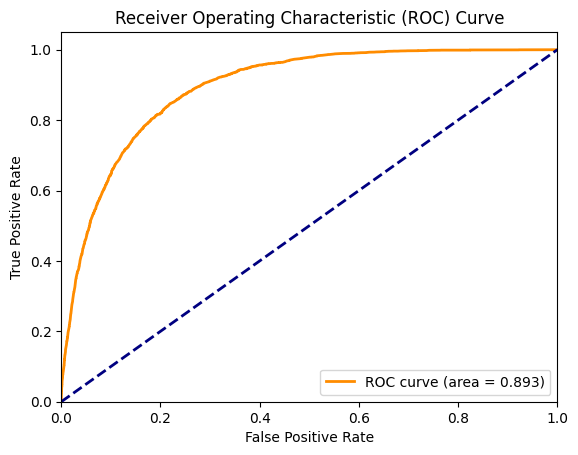

In [137]:
model = LGBMRanker(
    metric='auc'
)

# model = pipeline
model.fit(X_train_fe_used , y_train,
          group=train_groups,
        )

y_pred_proba = model.predict(X_val_fe_used, group=val_groups)
proba_to_predict = lambda proba, threshold=0.5: (proba > threshold).astype(int)
y_pred = proba_to_predict(y_pred_proba)

manual_auc_roc_draw(y_val, y_pred_proba)

In [138]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9485971422061648
Precision: 0.6368944462705458
Recall: 0.3530377668308703
Confusion Matrix:
 [[115070   3559]
 [  2758   1505]]


#### Random Forest

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


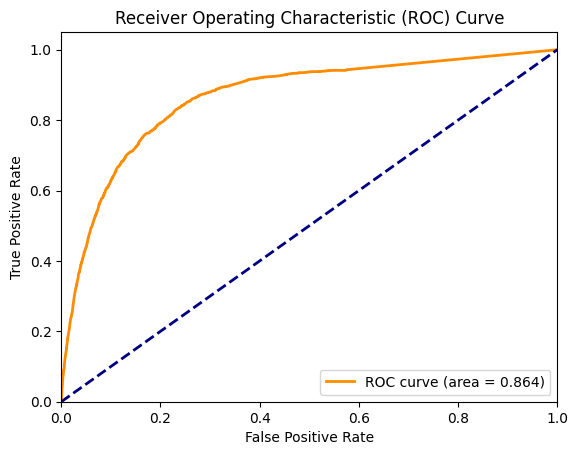

In [139]:
model = RandomForestClassifier()

# Fit the model on the training data
model.fit(X_train_fe_used, y_train)

# Predict on the testing data
y_pred = model.predict(X_val_fe_used)
y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]

manual_auc_roc_draw(y_val, y_pred_proba)

In [140]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9624141522637764
Precision: 0.6696810636697075
Recall: 0.11916490734224724
Confusion Matrix:
 [[117765    864]
 [  3755    508]]


##### CatBoost

Learning rate set to 0.144453
0:	learn: 0.4533845	total: 39.5ms	remaining: 39.5s
1:	learn: 0.3228919	total: 74.2ms	remaining: 37s
2:	learn: 0.2482042	total: 102ms	remaining: 34s
3:	learn: 0.1991956	total: 131ms	remaining: 32.7s
4:	learn: 0.1704857	total: 163ms	remaining: 32.4s
5:	learn: 0.1533808	total: 197ms	remaining: 32.7s
6:	learn: 0.1414342	total: 229ms	remaining: 32.4s
7:	learn: 0.1338631	total: 260ms	remaining: 32.3s
8:	learn: 0.1293190	total: 300ms	remaining: 33.1s
9:	learn: 0.1262341	total: 339ms	remaining: 33.6s
10:	learn: 0.1243882	total: 372ms	remaining: 33.5s
11:	learn: 0.1225836	total: 409ms	remaining: 33.6s
12:	learn: 0.1214772	total: 442ms	remaining: 33.5s
13:	learn: 0.1205507	total: 471ms	remaining: 33.2s
14:	learn: 0.1196060	total: 504ms	remaining: 33.1s
15:	learn: 0.1187019	total: 534ms	remaining: 32.8s
16:	learn: 0.1179923	total: 566ms	remaining: 32.7s
17:	learn: 0.1175623	total: 629ms	remaining: 34.3s
18:	learn: 0.1170670	total: 674ms	remaining: 34.8s
19:	learn: 0.

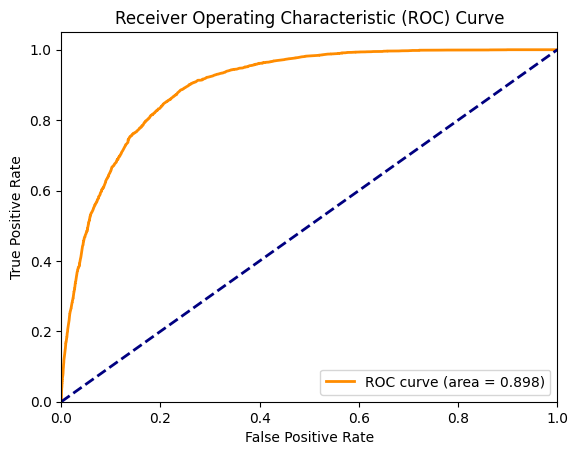

In [141]:
model = CatBoostClassifier()

# Fit the model on the training data
model.fit(X_train_fe_used, y_train)

# Predict on the testing data
y_pred = model.predict(X_val_fe_used)
y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]

manual_auc_roc_draw(y_val, y_pred_proba)

In [142]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9648878690232073
Precision: 0.715196106650593
Recall: 0.0755336617405583
Confusion Matrix:
 [[118255    374]
 [  3941    322]]


#### CatBoostRanker

0:	total: 667ms	remaining: 11m 5s
1:	total: 1.25s	remaining: 10m 23s
2:	total: 1.84s	remaining: 10m 11s
3:	total: 2.48s	remaining: 10m 18s
4:	total: 3.15s	remaining: 10m 26s
5:	total: 3.8s	remaining: 10m 29s
6:	total: 4.44s	remaining: 10m 29s
7:	total: 5.04s	remaining: 10m 25s
8:	total: 5.78s	remaining: 10m 35s
9:	total: 6.41s	remaining: 10m 34s
10:	total: 6.96s	remaining: 10m 25s
11:	total: 7.56s	remaining: 10m 22s
12:	total: 8.18s	remaining: 10m 21s
13:	total: 8.8s	remaining: 10m 19s
14:	total: 9.39s	remaining: 10m 16s
15:	total: 10.2s	remaining: 10m 28s
16:	total: 10.8s	remaining: 10m 24s
17:	total: 11.4s	remaining: 10m 23s
18:	total: 12s	remaining: 10m 21s
19:	total: 12.6s	remaining: 10m 18s
20:	total: 13.2s	remaining: 10m 15s
21:	total: 13.9s	remaining: 10m 17s
22:	total: 14.5s	remaining: 10m 16s
23:	total: 15.1s	remaining: 10m 12s
24:	total: 15.9s	remaining: 10m 18s
25:	total: 16.5s	remaining: 10m 18s
26:	total: 17.1s	remaining: 10m 16s
27:	total: 17.8s	remaining: 10m 16s
28:	tot

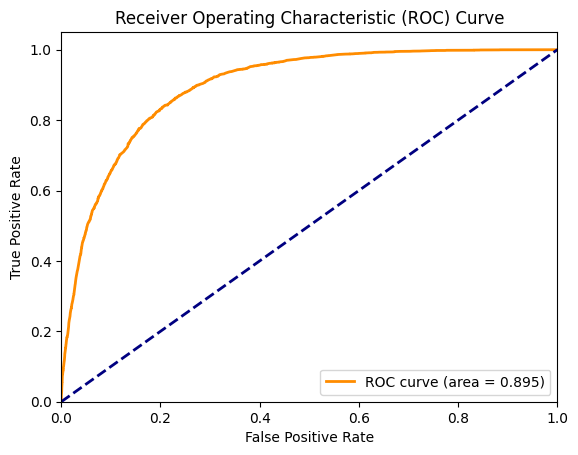

In [143]:
model = CatBoostRanker()

le = LabelEncoder()
kfold_group = le.fit_transform(X_train['query'])

# Fit the model on the training data
model.fit(X_train_fe_used, y_train, kfold_group)

# Predict on the testing data
y_pred_proba = model.predict(X_val_fe_used)
proba_to_predict = lambda proba, threshold=0.5: (proba > threshold).astype(int)
y_pred = proba_to_predict(y_pred_proba)

manual_auc_roc_draw(y_val, y_pred_proba)

In [144]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.6673583308921655
Precision: 0.5431003866197402
Recall: 0.9376026272577996
Confusion Matrix:
 [[78016 40613]
 [  266  3997]]


#### Naive Bayes

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


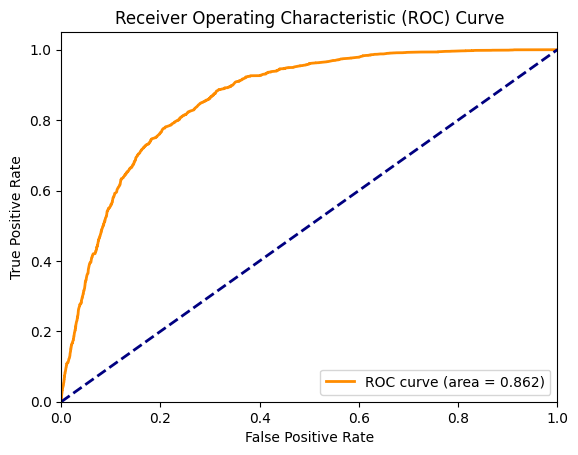

In [145]:
model = BernoulliNB()
model.fit(X_train_fe_used, y_train)

y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]
y_pred = model.predict(X_val_fe_used)

manual_auc_roc_draw(y_val, y_pred_proba)

In [146]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9245028154802591
Precision: 0.5877750272443097
Recall: 0.38681679568379074
Confusion Matrix:
 [[111965   6664]
 [  2614   1649]]


#### Logistic Regression

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


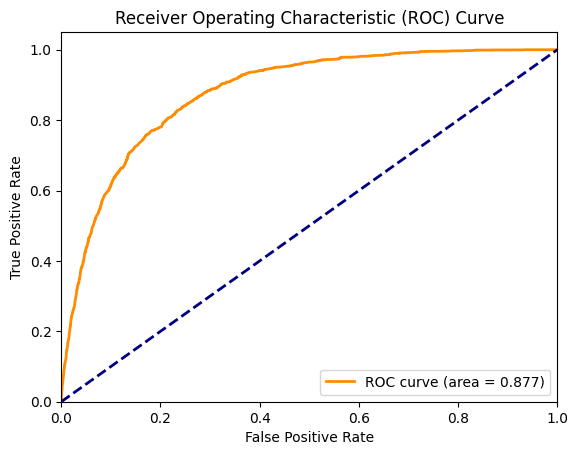

In [147]:
# Create and train the logistic regression model
model = LogisticRegression(random_state=43, max_iter=10000)
model.fit(X_train_fe_used, y_train)

# Predictions
y_pred = model.predict(X_val_fe_used)
y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]

manual_auc_roc_draw(y_val, y_pred_proba)

In [148]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9651319858086775
Precision: 0.7125967403327829
Recall: 0.028852920478536243
Confusion Matrix:
 [[118484    145]
 [  4140    123]]
